# Import Libraries and dataset

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
import warnings

df = pd.read_csv('../../65 Years of Weather Data Bangladesh (1948 - 2013).csv')

# Category 1

In [77]:
# Players to be selected
li = ["Chittagong (City-Ambagan)","Chittagong (IAP-Patenga)","Sandwip","Sitakunda","Kutubdia","Cox's Bazar","Teknaf","Sylhet","Srimangal","Rangamati"]

df_new=df[df.Station_Names.isin(li)]
df_new=df_new.drop(labels=["No","Station_Names","YEAR","Month","ALT","Station_Number"], axis=1)
df_new.head()

,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,X_COR,Y_COR,LATITUDE,LONGITUDE,Period
2748,31.566667,13.7,0.000000,70.333333,3.033333,0.1,6.411131,0.0,0.0,22.35,91.8166,2009.01
2749,32.400000,13.5,0.000000,67.000000,2.800000,0.9,6.411131,0.0,0.0,22.35,91.8166,2011.01
2750,30.700000,14.9,0.000000,75.000000,3.300000,1.5,6.411131,0.0,0.0,22.35,91.8166,2012.01
2751,31.600000,12.7,0.000000,69.000000,3.000000,0.3,6.411131,0.0,0.0,22.35,91.8166,2013.01
2752,34.833333,16.7,0.333333,62.333333,3.166667,0.7,6.411131,0.0,0.0,22.35,91.8166,2009.02


In [78]:
z = df_new["Wind_Speed"]

df_new = df_new.drop(labels=["Wind_Speed","X_COR","Y_COR","Bright_Sunshine"], axis=1)
df_new['Wind_Speed'] = z
df_new.head()

,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Cloud_Coverage,LATITUDE,LONGITUDE,Period,Wind_Speed
2748,31.566667,13.7,0.000000,70.333333,0.1,22.35,91.8166,2009.01,3.033333
2749,32.400000,13.5,0.000000,67.000000,0.9,22.35,91.8166,2011.01,2.800000
2750,30.700000,14.9,0.000000,75.000000,1.5,22.35,91.8166,2012.01,3.300000
2751,31.600000,12.7,0.000000,69.000000,0.3,22.35,91.8166,2013.01,3.000000
2752,34.833333,16.7,0.333333,62.333333,0.7,22.35,91.8166,2009.02,3.166667


In [79]:
X = df_new.iloc[:,:-1]
Y = df_new.iloc[:,-1]

In [80]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

# Preprocessiong with Standard Scaler 

In [81]:
# Standard Scaler

from sklearn.preprocessing import StandardScaler

numeric=['Max_Temp', 'Min_Temp','Rainfall', 'Relative_Humidity', 'Cloud_Coverage', 'LATITUDE', 'LONGITUDE', 'Period']
# scaler = sc.fit_transform(trainX[numeric])

sc=StandardScaler()
scaler = sc.fit(trainX[numeric])
trainX_scaled = scaler.transform(trainX[numeric])
testX_scaled = scaler.transform(testX[numeric])


# Random Forest Regression

In [82]:
from sklearn.ensemble import RandomForestRegressor
  
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(trainX, trainY) 

#  Prediction
Y_pred_RF = regressor.predict(testX)

df_temp = pd.DataFrame({'Actual': testY, 'Predicted': Y_pred_RF})
df_temp.head()

,Actual,Predicted
18145,1.4,0.823648
20169,1.4,1.315000
15401,0.1,0.595000
16781,0.3,0.610000
5444,0.7,1.234000


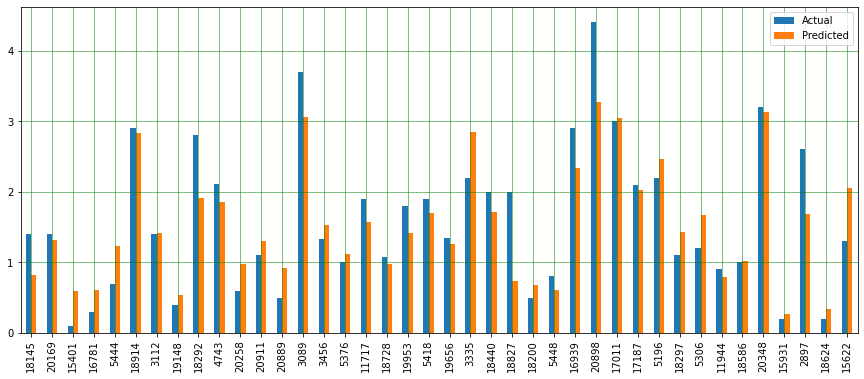

In [83]:
df_temp = df_temp.head(40)
df_temp.plot(kind='bar',figsize=(15,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.show()

In [84]:
from sklearn.metrics import r2_score
score= r2_score(testY,Y_pred_RF)
print(score)

0.8244669684532385


In [85]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, Y_pred_RF))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, Y_pred_RF))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, Y_pred_RF)))

Mean Absolute Error: 0.348624227875
Mean Squared Error: 0.2464239785280337
Root Mean Squared Error: 0.4964110983127127


# XGBoost Regression

In [86]:
from xgboost import XGBRegressor

RegModel=XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
XGB=RegModel.fit(trainX_scaled,trainY)
prediction_XGB=XGB.predict(testX_scaled)

[18:37:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [87]:
df_temp = pd.DataFrame({'Actual': testY, 'Predicted': prediction_XGB})
df_temp.head()

,Actual,Predicted
18145,1.4,0.710532
20169,1.4,1.209978
15401,0.1,0.780107
16781,0.3,0.720045
5444,0.7,1.271587


In [88]:
#Measuring Goodness of fit in Training data
from sklearn import metrics
print('R2 Value:',metrics.r2_score(testY, prediction_XGB))

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, prediction_XGB))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, prediction_XGB))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, prediction_XGB)))

R2 Value: 0.7766098137314306
Mean Absolute Error: 0.3975210848326853
Mean Squared Error: 0.3136087719749465
Root Mean Squared Error: 0.560007832065719


In [89]:
parameters = {
    'n_estimators': [3000, 3500],
    'max_depth': [1,2,3,4],
}
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(XGB, parameters,cv=5,n_jobs=-1)
grid.fit(trainX_scaled, trainY)

print(grid.best_params_)

[18:40:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 4, 'n_estimators': 3000}


In [90]:
grid_predictionsXGB = grid.predict(testX_scaled) 
df_temp2 = pd.DataFrame({'Actual': testY, 'Predicted': grid_predictionsXGB})
df_temp2.head()

,Actual,Predicted
18145,1.4,0.856512
20169,1.4,1.268366
15401,0.1,0.482220
16781,0.3,0.888235
5444,0.7,1.046939


In [91]:
#Measuring Goodness of fit in Training data
from sklearn import metrics

print('R2 Value:',metrics.r2_score(testY, grid_predictionsXGB))

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, grid_predictionsXGB))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, grid_predictionsXGB))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, grid_predictionsXGB)))

R2 Value: 0.8327738163044272
Mean Absolute Error: 0.34940255194747005
Mean Squared Error: 0.23476231873398165
Root Mean Squared Error: 0.48452277421601314


# MLP Regression

In [92]:
# MLPRegressor

from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(hidden_layer_sizes=(150,100,50),
                       max_iter = 300,activation = 'relu',
                       solver = 'adam')

mlp_reg.fit(trainX_scaled, trainY)

MLPRegressor(hidden_layer_sizes=(150, 100, 50), max_iter=300)

In [93]:
y_pred = mlp_reg.predict(testX_scaled)
df_temp = pd.DataFrame({'Actual': testY, 'Predicted': y_pred})
df_temp.head()

,Actual,Predicted
18145,1.4,0.653577
20169,1.4,1.381958
15401,0.1,0.679665
16781,0.3,0.984680
5444,0.7,1.163225


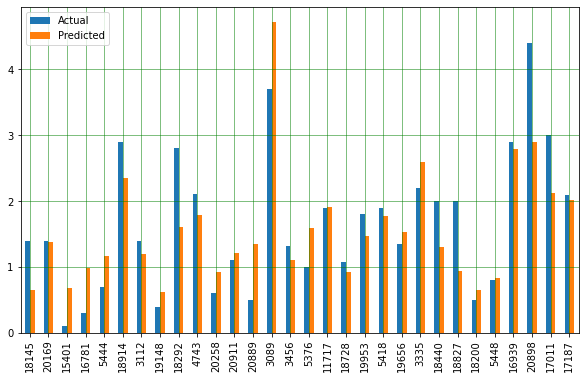

In [94]:
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.show()

Text(0, 0.5, 'Cost')

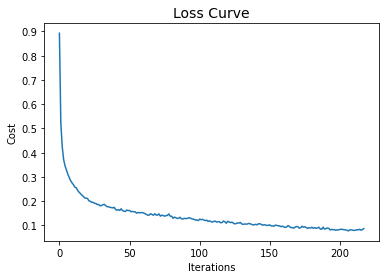

In [95]:
plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [96]:
from sklearn.metrics import r2_score
score= r2_score(testY,y_pred)
score

0.7355118009452486

In [97]:
param_grid = {
    'hidden_layer_sizes': [(150, 100, 50)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(mlp_reg, param_grid, n_jobs= -1, cv=5)
grid.fit(trainX_scaled, trainY)

print(grid.best_params_) 

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [98]:
grid_predictions = grid.predict(testX_scaled) 
df_temp2 = pd.DataFrame({'Actual': testY, 'Predicted': grid_predictions})
df_temp2.head()

,Actual,Predicted
18145,1.4,0.965034
20169,1.4,1.226234
15401,0.1,0.265215
16781,0.3,0.427045
5444,0.7,0.936169


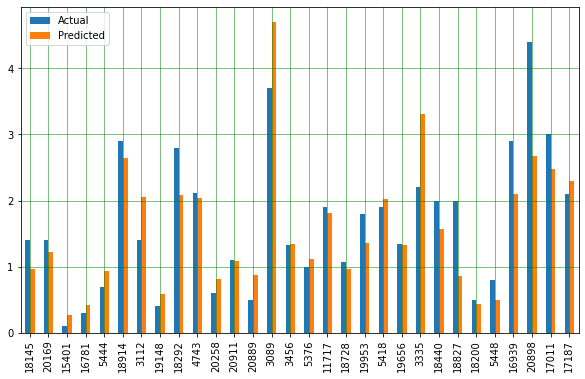

In [99]:
df_temp2 = df_temp2.head(30)
df_temp2.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.show()

In [100]:
#Measuring Goodness of fit in Training data
from sklearn import metrics
print('R2 Value:',metrics.r2_score(testY, grid_predictions))

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, grid_predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, grid_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, grid_predictions)))

R2 Value: 0.7824889361040587
Mean Absolute Error: 0.3972374361986221
Mean Squared Error: 0.3053553013173156
Root Mean Squared Error: 0.5525896319307082


In [101]:
mean_pred=( Y_pred_RF+grid_predictionsXGB+ grid_predictions)/3
df_temp2 = pd.DataFrame({'Actual': testY, 'pred_RF': Y_pred_RF,'pred_XGB':prediction_XGB,'pred_MLP': grid_predictions,'mean_pred':mean_pred})
df_temp2.head()

,Actual,pred_RF,pred_XGB,pred_MLP,mean_pred
18145,1.4,0.823648,0.710532,0.965034,0.881732
20169,1.4,1.315000,1.209978,1.226234,1.269867
15401,0.1,0.595000,0.780107,0.265215,0.447478
16781,0.3,0.610000,0.720045,0.427045,0.641760
5444,0.7,1.234000,1.271587,0.936169,1.072370


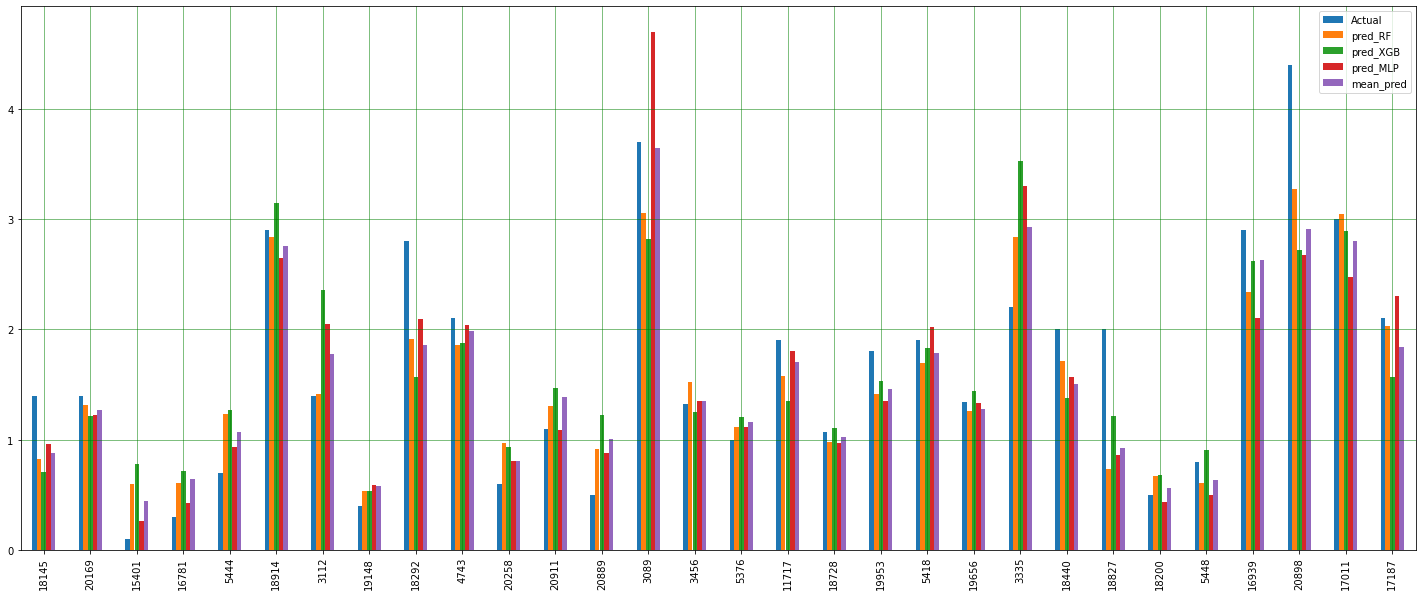

In [102]:
df_temp2 = df_temp2.head(30)
df_temp2.plot(kind='bar',figsize=(25,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [103]:
mean_pred=( Y_pred_RF+prediction_XGB+ grid_predictions)/3
df_temp2 = pd.DataFrame({'Actual': testY, 'mean_pred':mean_pred})
df_temp2.head()

,Actual,mean_pred
18145,1.4,0.833072
20169,1.4,1.250404
15401,0.1,0.546774
16781,0.3,0.585697
5444,0.7,1.147252


In [104]:
print('R2 Value:',metrics.r2_score(testY, mean_pred)*100,"%")
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, mean_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, mean_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, mean_pred)))

R2 Value: 82.3990944315365 %
Mean Absolute Error: 0.353024725785647
Mean Squared Error: 0.24709225025385387
Root Mean Squared Error: 0.4970837457147979


In [ ]:
# from sklearn.model_selection import train_test_split
# trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

# Ridge Regression 

In [43]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge=Ridge()
parameters={'alpha':[0.001,0.01,0.1]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(trainX,trainY)

GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [44]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.1}
-1.0716952012202476


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Wind_Speed', ylabel='Density'>

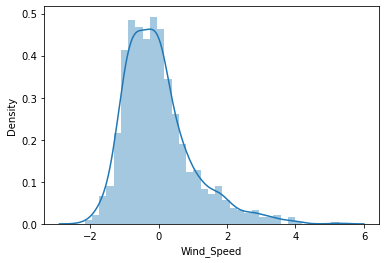

In [33]:
prediction_ridge=ridge_regressor.predict(testX)
import seaborn as sns

sns.distplot(testY-prediction_ridge)

In [45]:
df_temp2 = pd.DataFrame({'Actual': testY, 'RR_pred':prediction_ridge})
df_temp2.head()

,Actual,RR_pred
4988,1.400000,2.090564
3307,0.600000,2.496513
19301,0.400000,0.481545
19161,0.100000,1.425778
17245,0.934043,1.792522


In [46]:
print('R2 Value:',metrics.r2_score(testY, prediction_ridge)*100,"%")
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, prediction_ridge))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, prediction_ridge))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, prediction_ridge)))

R2 Value: 31.775085559438153 %
Mean Absolute Error: 0.7529466025187702
Mean Squared Error: 1.0067937087651706
Root Mean Squared Error: 1.003391104587424


In [37]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

lasso_regressor.fit(trainX,trainY)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1082.034244561382, tolerance: 0.5275403082779192
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213.1268514776025, tolerance: 0.5253485896262046
  model = cd_fast.enet_coordinate_descent(


{'alpha': 1e-08}
-1.071695956031414


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Wind_Speed', ylabel='Density'>

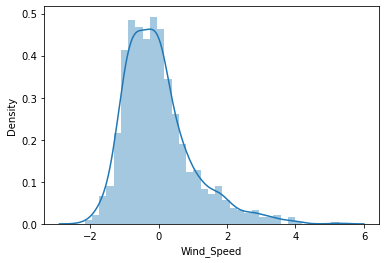

In [38]:
prediction_lasso=lasso_regressor.predict(testX)
import seaborn as sns

sns.distplot(testY-prediction_ridge)

In [39]:
df_temp2 = pd.DataFrame({'Actual': testY, 'RR_pred':prediction_lasso})
df_temp2.head()

,Actual,RR_pred
4988,1.400000,2.090551
3307,0.600000,2.497575
19301,0.400000,0.481218
19161,0.100000,1.425891
17245,0.934043,1.794012


In [40]:
print('R2 Value:',metrics.r2_score(testY, prediction_lasso)*100,"%")
print('Mean Absolute Error:', metrics.mean_absolute_error(testY, prediction_lasso))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, prediction_lasso))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, prediction_lasso)))

R2 Value: 31.775845319483466 %
Mean Absolute Error: 0.7530049269060043
Mean Squared Error: 1.006782497001256
Root Mean Squared Error: 1.0033855176357969


In [ ]:
# from sklearn.model_selection import train_test_split
# trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2)

# improve accuracy 

In [7]:
df_new.head(3)

,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Cloud_Coverage,Bright_Sunshine,LATITUDE,LONGITUDE,Period,Wind_Speed
2748,31.566667,13.7,0.0,70.333333,0.1,6.411131,22.35,91.8166,2009.01,3.033333
2749,32.400000,13.5,0.0,67.000000,0.9,6.411131,22.35,91.8166,2011.01,2.800000
2750,30.700000,14.9,0.0,75.000000,1.5,6.411131,22.35,91.8166,2012.01,3.300000


In [8]:
print(f'Dataset size: {trainX.shape}')

Dataset size: (4560, 9)


In [11]:
print(f'Dataset size: {testX.shape}')

Dataset size: (1140, 9)


In [12]:
df_new.isnull().sum().sort_values(ascending=False)/df_new.shape[0]

Wind_Speed           0.0
Period               0.0
LONGITUDE            0.0
LATITUDE             0.0
Bright_Sunshine      0.0
Cloud_Coverage       0.0
Relative_Humidity    0.0
Rainfall             0.0
Min_Temp             0.0
Max_Temp             0.0
dtype: float64

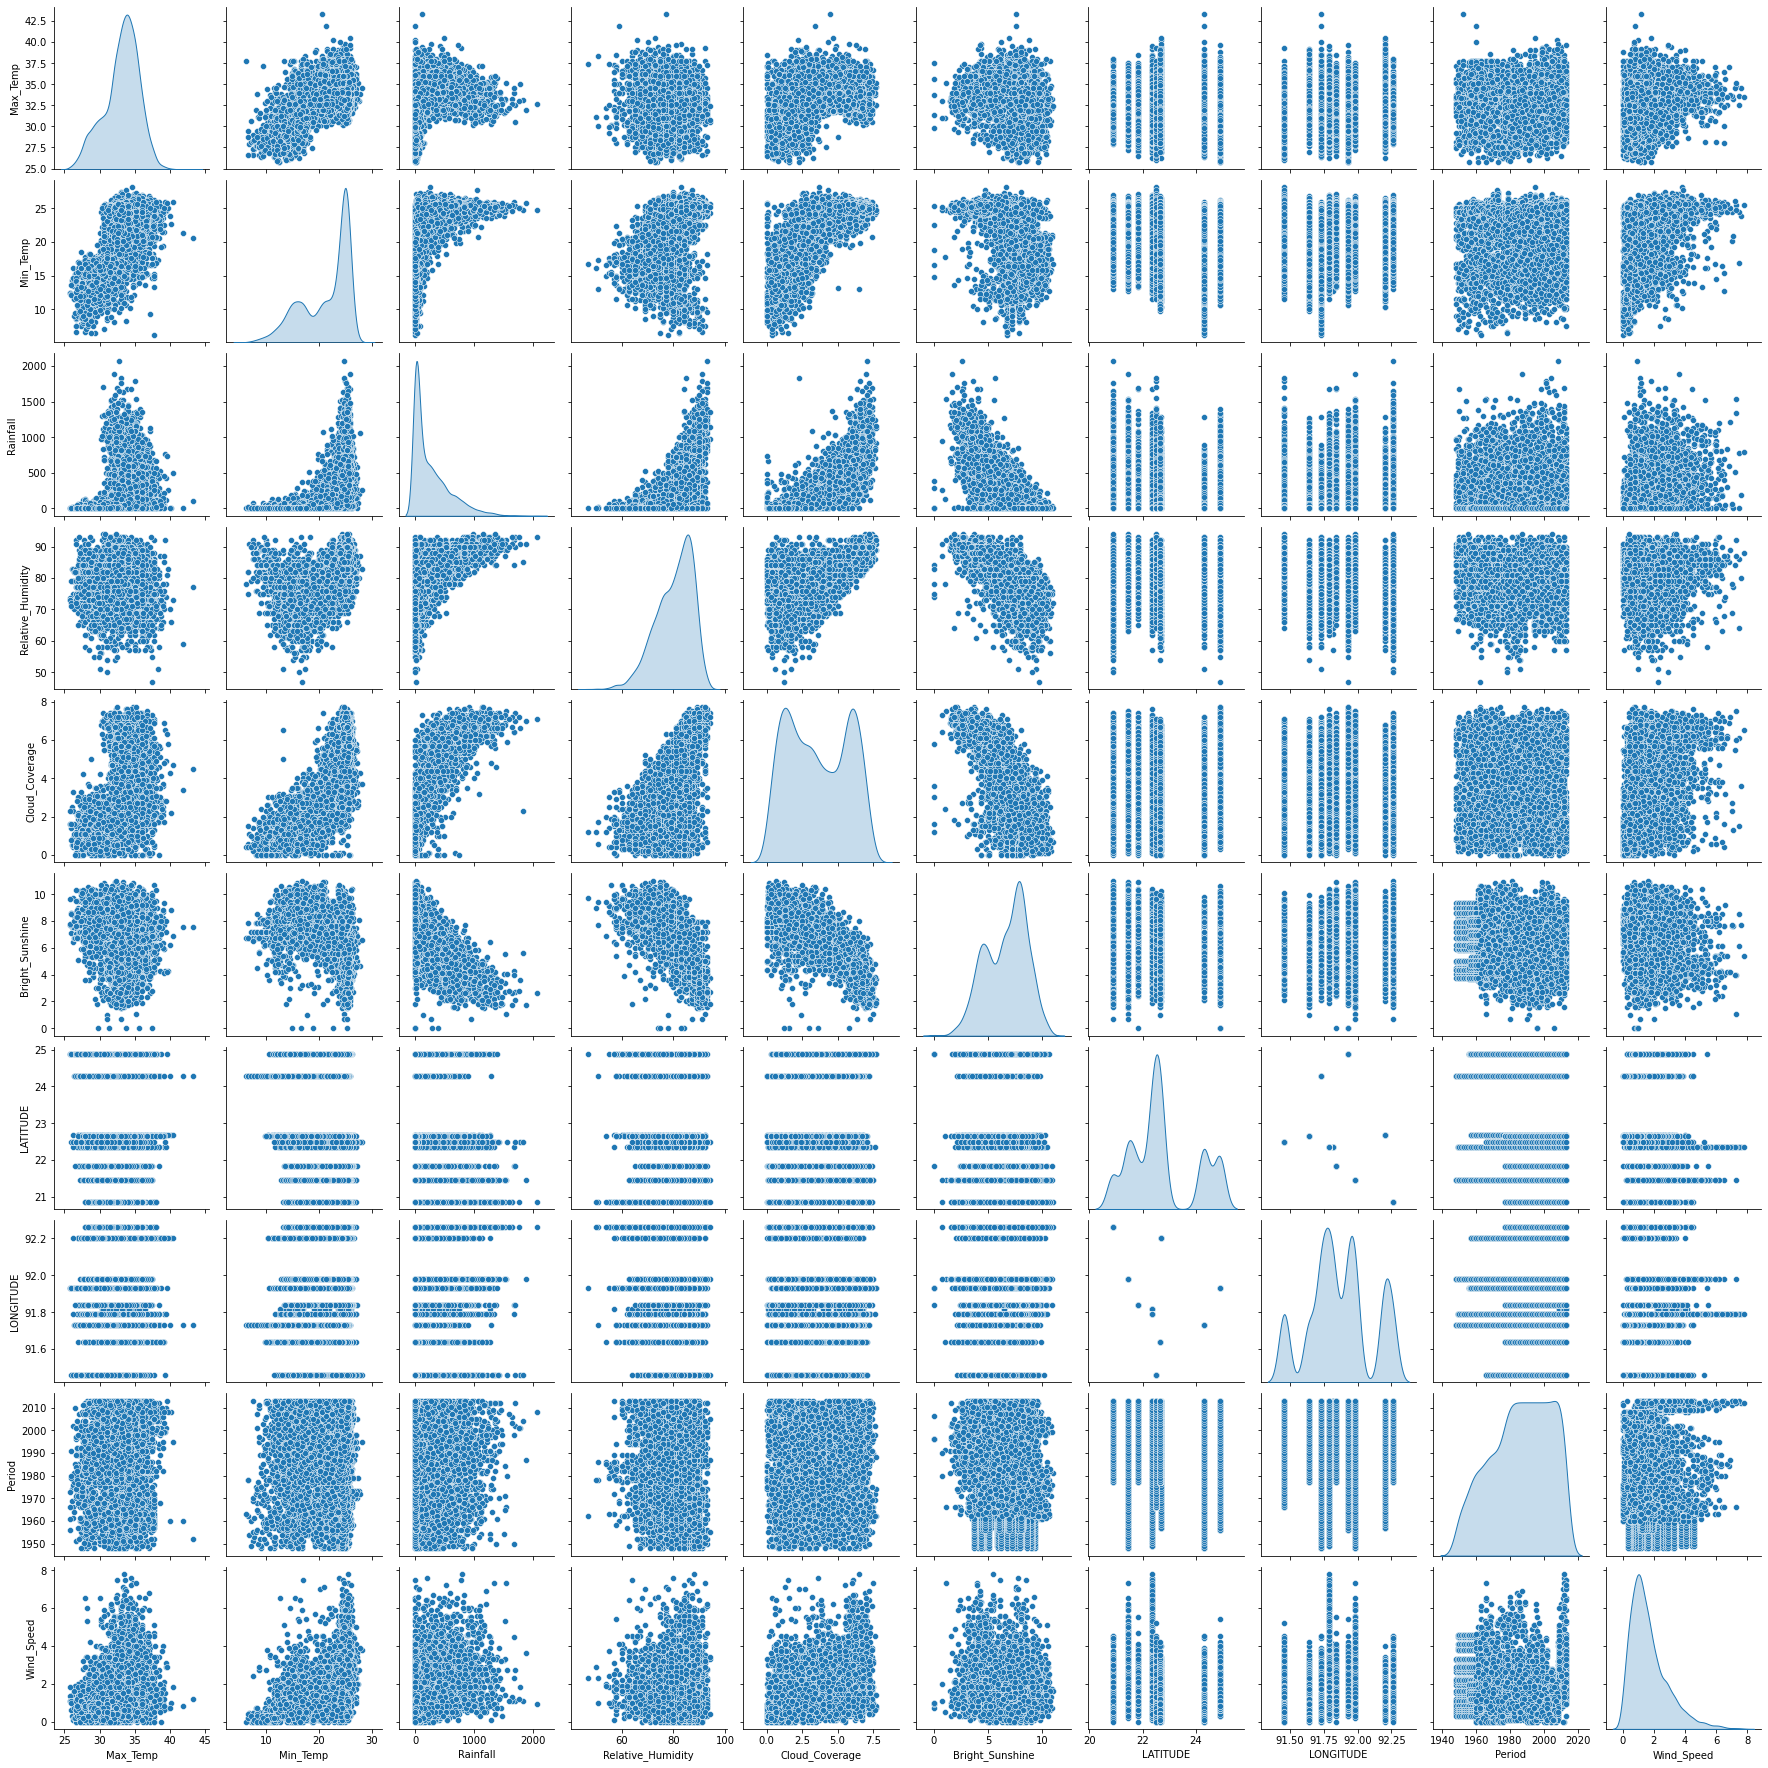

In [14]:
import seaborn as sns
sns.pairplot(data=df_new, diag_kind='kde')